In [1]:
library(cowplot)
library(tidyverse)

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.1       ✔ purrr   0.3.2  
✔ tidyr   0.8.3       ✔ dplyr   0.8.0.1
✔ readr   1.3.1       ✔ stringr 1.4.0  
✔ tibble  2.1.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks stats::filter()
✖ purrr::flatten()  masks jsonlite::flatten()
✖ cowplot::ggsave() masks ggplot2::ggsave()
✖ dplyr::lag()      masks stats::lag()


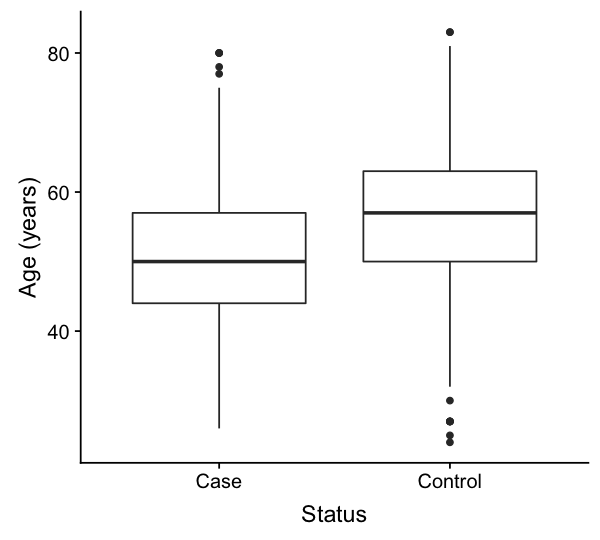

In [2]:
fam <- read_delim('~/data/genesis/genesis_2019.fam', delim = ' ', col_names = FALSE, col_types = 'cciiii')
age <- read_tsv('~/data/genesis/raw/CT_age_cens_tronq.cov', col_types = 'ccd')

options(repr.plot.width=5, repr.plot.height=4.5)
inner_join(fam, age, by = c('X1' = 'FID', 'X2' = 'IID')) %>%
    mutate(Status = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(x = Status, y = AGE)) +
        geom_boxplot() +
        labs(y = 'Age (years)')

# Gene-level analyses

## All SNPs vs. LD pruned

In [3]:
vegas <- inner_join(read_tsv('scored_genes.vegas.txt'), read_tsv('scored_genes.vegas.full.txt'), 
                    by = c('Chr','Gene','Start','Stop'), suffix = c('_pruned', '_full'))

Parsed with column specification:
cols(
  Chr = col_double(),
  Gene = col_character(),
  nSNPs = col_double(),
  nSims = col_double(),
  Start = col_double(),
  Stop = col_double(),
  Test = col_double(),
  Pvalue = col_double(),
  `Top-0.1-pvalue` = col_double(),
  `Best-SNP` = col_character(),
  `SNP-pvalue` = col_double()
)
Parsed with column specification:
cols(
  Chr = col_double(),
  Gene = col_character(),
  nSNPs = col_double(),
  nSims = col_double(),
  Start = col_double(),
  Stop = col_double(),
  Test = col_double(),
  Pvalue = col_double(),
  `Top-0.1-pvalue` = col_double(),
  `Best-SNP` = col_character(),
  `SNP-pvalue` = col_double()
)


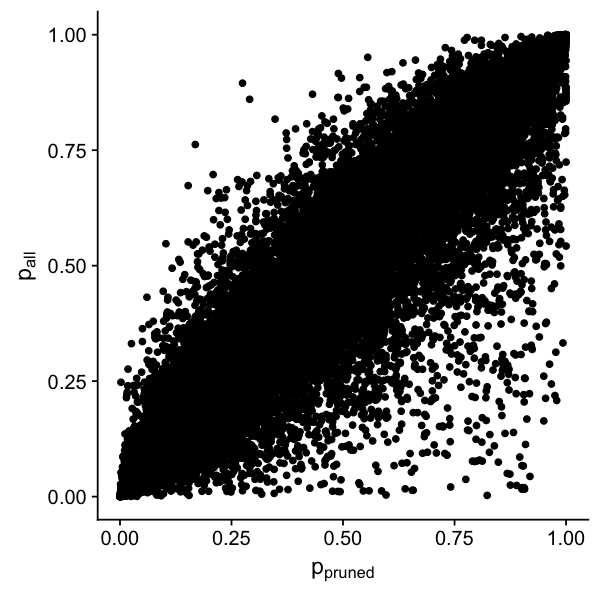

In [4]:
options(repr.plot.width=5, repr.plot.height=5)
ggplot(vegas, aes(Pvalue_pruned, Pvalue_full)) +
    geom_point() +
    labs(x = bquote('p' [pruned]), y = bquote('p' [all]))

Conclusion: we should not LD prune our data for VEGAS-score computation.

## All SNPs: age adjustment vs. no correction

In [5]:
vegas <- inner_join(read_tsv('scored_genes.vegas.no_covars.txt'), read_tsv('scored_genes.vegas.full.txt'), 
                    by = c('Chr','Gene','Start','Stop'), suffix = c('_no_covars', '_covars')) %>%
    arrange(Pvalue_covars) %>%
    mutate(., q_covars = seq(1, nrow(.))/nrow(.)) %>%
    arrange(Pvalue_no_covars) %>%
    mutate(., q_no_covars = seq(1, nrow(.))/nrow(.))

Parsed with column specification:
cols(
  Chr = col_double(),
  Gene = col_character(),
  nSNPs = col_double(),
  nSims = col_double(),
  Start = col_double(),
  Stop = col_double(),
  Test = col_double(),
  Pvalue = col_double(),
  `Top-0.1-pvalue` = col_double(),
  `Best-SNP` = col_character(),
  `SNP-pvalue` = col_double()
)
Parsed with column specification:
cols(
  Chr = col_double(),
  Gene = col_character(),
  nSNPs = col_double(),
  nSims = col_double(),
  Start = col_double(),
  Stop = col_double(),
  Test = col_double(),
  Pvalue = col_double(),
  `Top-0.1-pvalue` = col_double(),
  `Best-SNP` = col_character(),
  `SNP-pvalue` = col_double()
)


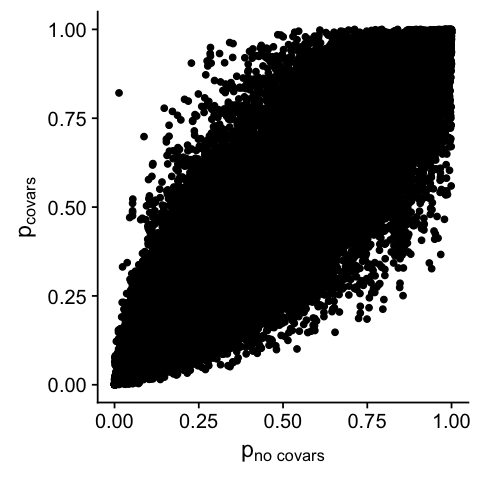

In [6]:
options(repr.plot.width=4, repr.plot.height=4)
ggplot(vegas, aes(Pvalue_no_covars, Pvalue_covars)) +
    geom_point() +
    labs(x = bquote('p' ['no covars']), y = bquote('p' ['covars']))

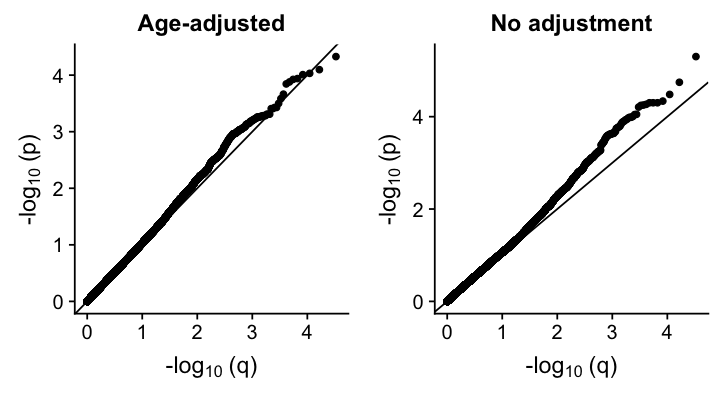

In [7]:
no_covars <- ggplot(vegas, aes(-log10(q_no_covars), -log10(Pvalue_no_covars))) +
    geom_point() + 
    geom_abline(slope = 1) +
    labs(title = 'No adjustment', x = bquote('-log' [10] ~'(q)'), y = bquote('-log' [10] ~'(p)'))

covars <- ggplot(vegas, aes(-log10(q_covars), -log10(Pvalue_covars))) +
    geom_point() + 
    geom_abline(slope = 1) +
    labs(title = 'Age-adjusted', x = bquote('-log' [10] ~'(q)'), y = bquote('-log' [10] ~'(p)'))

options(repr.plot.width=6, repr.plot.height=3.3)
plot_grid(covars, no_covars)

# SNP-level analyses

In [8]:
snps <- inner_join(read_tsv('univariate_models.covars.tsv') %>% filter(TEST == 'ADD'), 
                   read_tsv('univariate_models.no_covars.tsv'),
                   by = c('CHR', 'SNP', 'BP', 'A1'), suffix = c('_covars', '_no_covars')) %>%
    arrange(P_covars) %>%
    mutate(., q_covars = seq(1, nrow(.))/nrow(.)) %>%
    arrange(P_no_covars) %>%
    mutate(., q_no_covars = seq(1, nrow(.))/nrow(.))

Parsed with column specification:
cols(
  CHR = col_double(),
  SNP = col_character(),
  BP = col_double(),
  A1 = col_double(),
  TEST = col_character(),
  NMISS = col_double(),
  OR = col_double(),
  STAT = col_double(),
  P = col_double()
)
Parsed with column specification:
cols(
  CHR = col_double(),
  SNP = col_character(),
  BP = col_double(),
  A1 = col_double(),
  F_A = col_double(),
  F_U = col_double(),
  A2 = col_double(),
  CHISQ = col_double(),
  P = col_double(),
  OR = col_double()
)


Warning message:
“Removed 27 rows containing missing values (geom_point).”

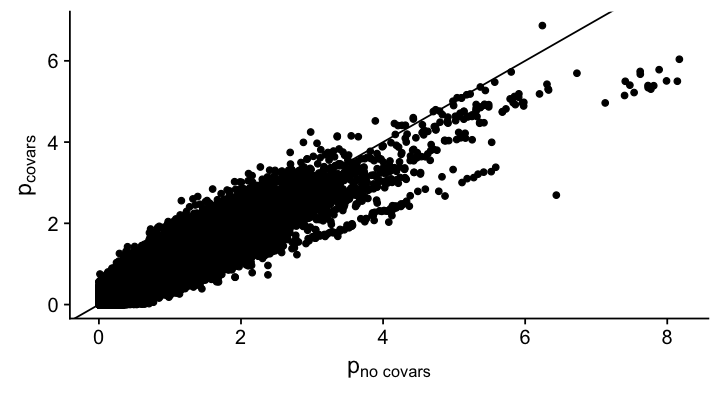

In [9]:
ggplot(snps, aes(-log10(P_no_covars), -log10(P_covars))) +
    geom_point() +
    geom_abline(slope = 1) +
    labs(x = bquote('p' ['no covars']), y = bquote('p' ['covars']))

Warning message:
“Removed 27 rows containing missing values (geom_point).”

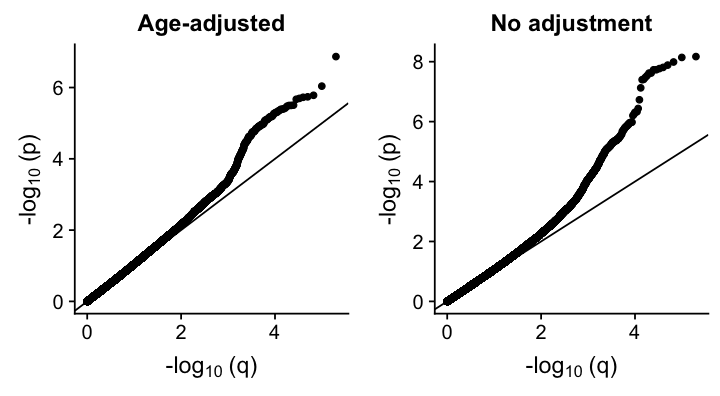

In [10]:
no_covars <- ggplot(snps, aes(-log10(q_no_covars), -log10(P_no_covars))) +
    geom_point() + 
    geom_abline(slope = 1) +
    labs(title = 'No adjustment', x = bquote('-log' [10] ~'(q)'), y = bquote('-log' [10] ~'(p)'))

covars <- ggplot(snps, aes(-log10(q_covars), -log10(P_covars))) +
    geom_point() + 
    geom_abline(slope = 1) +
    labs(title = 'Age-adjusted', x = bquote('-log' [10] ~'(q)'), y = bquote('-log' [10] ~'(p)'))

options(repr.plot.width=6, repr.plot.height=3.3)
plot_grid(covars, no_covars)

In [11]:
sum(snps$P_no_covars < (0.05/nrow(snps)))

[1] 16

In [12]:
sum(snps$P_covars < (0.05/nrow(snps)), na.rm = T)

[1] 1

Conclusion: we should not adjust by age.